In [2]:
### PREAMBLE
# Differentiable Convex Optimization Layers
# CVXPY creates powerful new PyTorch and TensorFlow layers
# Akshay Agrawal, Brandon Amos, Shane Barratt, Stephen Boyd, Steven Diamond, J. Zico Kolter
# wideimg: ./overview.png

import numpy as np
import numpy.random as npr

import torch
from torch import nn
import torch.nn.functional as F

import os
import sys
import shutil

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
plt.style.use('bmh')
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)

def to_np(x):
    return x.detach().numpy()

def inConstraints(x, G, h):
    return int(np.all(G.dot(x) <= h))

def plotConstraints(G0, h0, G1=None, h1=None, xmin=0, xmax=1, ymin=0, ymax=1):
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 600),
                         np.linspace(ymin, ymax, 600))
    xxFlat = xx.ravel()
    yyFlat = yy.ravel()
    gridX = np.vstack((xxFlat, yyFlat)).T

    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.axis([xmin, xmax, ymin, ymax])

    zzFlat0 = []
    zzFlat1 = []
    _xmin = _xmax = _ymin = _ymax = 0.5
    for i in range(len(gridX)):
        xi = gridX[i]
        t = inConstraints(xi, G0, h0)
        zzFlat0.append(t)
        if t:
            _xmin = min(_xmin, xi[0])
            _xmax = max(_xmax, xi[0])
            _ymin = min(_ymin, xi[1])
            _ymax = max(_ymax, xi[1])
        if G1 is not None:
            t = inConstraints(xi, G1, h1)
            zzFlat1.append(t)

    zz0 = np.array(zzFlat0).reshape(xx.shape)
    cs = ax.contourf(xx, yy, zz0, cmap=cm.Blues, alpha=0.5)
    cs.cmap.set_under('white')
    cs.set_clim(0.5, 1.0)

    if G1 is not None:
        zz1 = np.array(zzFlat1).reshape(xx.shape)
        cs = ax.contourf(xx, yy, zz1, cmap=cm.Reds, alpha=0.5)
        cs.cmap.set_under('white')
        cs.set_clim(0.5, 1.0)

    scale = 0.1
    _xmin, _ymin = [z-scale*z for z in [_xmin, _ymin]]
    _xmax, _ymax = [z+scale*z for z in [_xmax, _ymax]]
    ax.axis([_xmin, _xmax, _ymin, _ymax])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    return fig, ax

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

---

In this tutorial we introduce our library for creating differentiable
optimization layers in PyTorch and TensorFlow.
You can find more details in:

1. [Our NeurIPS 2019 paper](http://web.stanford.edu/~boyd/papers/pdf/diff_cvxpy.pdf)
2. [Our cvxgrp/cvxpylayers repo](https://github.com/cvxgrp/cvxpylayers) and
   our other [PyTorch](https://github.com/cvxgrp/cvxpylayers/tree/master/examples/torch)
   and [TensorFlow](https://github.com/cvxgrp/cvxpylayers/tree/master/examples/tf)
   examples
3. <a href="https://www.cvxpy.org/">CVXPY</a> and
   <a href="https://www.cvxpy.org/tutorial/advanced/index.html#dpp">Disciplined Parametrized Programming</a>

----
[Optimization](https://arxiv.org/abs/1703.00443)
[layers](https://arxiv.org/abs/1607.05447)
[add](https://arxiv.org/abs/1810.13400)
[domain-specific](https://arxiv.org/abs/1804.05098)
[knowledge](https://arxiv.org/abs/1905.12149)
[or](https://arxiv.org/abs/1909.04630)
[learnable](https://arxiv.org/abs/1906.04292)
[hard](http://proceedings.mlr.press/v22/domke12/domke12.pdf)
[constraints](https://arxiv.org/abs/1802.08665)
[to](https://arxiv.org/abs/1703.04529)
[machine](https://arxiv.org/abs/1909.04866)
[learning](https://arxiv.org/abs/1907.05912)
[models.](https://arxiv.org/abs/1904.03758)
Many of these layers solve *convex* and *constrained*
optimization problems of the form
\begin{equation}
\begin{aligned}
  x^\star(\theta) = {\rm argmin}_x & \; f(x; \theta)\ \\
  {\rm subject\ to} & \; g(x; \theta) \leq 0 \\
  & \; h(x; \theta) = 0
\end{aligned}
\end{equation}
with parameters $\theta$,
objective $f$, and constraint functions $g,h$
and do end-to-end learning through them with respect
to $\theta$.

In this tutorial we introduce our new library
[cvxpylayers](https://github.com/cvxgrp/cvxpylayers)
for easily creating differentiable new convex optimization layers.
This lets you express your layer with the [CVXPY](https://cvxpy.org)
domain specific language as usual and then export the CVXPY object
to an efficient batched and differentiable layer with
a single line of code.
This project turns *every* convex optimization problem expressed
in CVXPY into a differentiable layer.
Before this, implementing these layers has required manually
implementing efficient problem-specific batched solvers
and manually implicitly differentiating the optimization problem.
Most prior work on differentiable optimization layers has
used PyTorch and in our project we significantly bring
differentiable convex optimization layers to TensorFlow
so that it is just as easy now.

**Overview.**
After going deeper into the background and motivation of
optimization layers, we will present an interpretation of
the ReLU, sigmoid, and softmax functions as optimization layers
and show how they can be implemented with `cvxpylayers`.
We will then go on to show how to add more sophisticated
projection and constraints to neural network layers with
`cvxpylayers`.

# Background and Motivation

[See Sections 2 and 3 of our paper for a more complete overview of the related work in this space.](http://web.stanford.edu/~boyd/papers/pdf/diff_cvxpy.pdf)

## Domain-specific modeling components for machine learning
Modeling in today's machine learning landscape typically
involves connecting together differentiable components
and building block in a way that is end-to-end trainable.
Historically and conventionally, practitioners can
model with well-known linear operations such as fully
connected layers and convolutions composed with
non-linear activation functions such as the ReLU
and sigmoid. Projections onto the simplex can be
done with the softmax function.
This modeling approach provides an incredibly expressive
function class that can universally approximate any
function under mild restrictions.
However this expressiveness comes at the cost of
trading off model interpretability and data efficiency
in many cases.
In an attempt to improve this, more sophisticated and
specialized modeling components are being proposed,
analyzed, and studied in the community that can be
integrated with the rest of the machine learning pipeline
and learned with standard gradient-based methods.

The role of domain-specific knowledge in the machine learning
and computer vision fields has been an active discussion topic
over the past decade and beyond.
Historically, domain knowledge such as fixed hand-crafted
feature and edge detectors were rigidly part of the
computer vision pipeline and have been overtaken by
learnable convolutional models
To highlight the power of convolutional architectures, they
provide a reasonable prior for vision tasks even without learning.
Machine learning models extend far beyond the reach
of vision tasks and the community has a growing interest
on domain-specific priors rather than just using
fully-connected architectures.
These priors ideally can be integrated as end-to-end
learnable modules into a larger system that are
learned as a whole with gradient-based information.
In contrast to pure fully-connected architectures,
specialized submodules ideally improve the data
efficiency of the model, add interpretability,
and enable grey-box verification.
More examples include
[differentiable beam search](https://arxiv.org/abs/1708.00111);
[differentiable dynamic programming](https://arxiv.org/abs/1802.03676);
[a differentiable protein simulator](https://openreview.net/forum?id=Byg3y3C9Km);
[a differentiable particle filter](https://arxiv.org/abs/1805.11122);
[neural ordinary differential equations](https://arxiv.org/abs/1806.07366) and
[applications to a reversible generative models](https://arxiv.org/abs/1810.01367);
relational reasoning on sets, graphs, and trees;
geometry-based priors;
memory;
attention mechanisms;
capsule networks;
and program synthesis.

## Our focus: Optimization as a layer

In this tutorial, we consider optimization as a layer for machine learning
that can be used to inject domain-specific knowledge into
the inference procedure.
We argue that in addition to optimization's role in
machine learning for parameter optimization or architecture
search (**neither** of which we focus on), optimization
should have a third role in machine learning as a
modeling component.
Optimization is useful because many sophisticated operations can
be expressed as optimization problems, and even outside of the
field of machine learning optimization is widely used
for modeling.
Traditional machine learning methods may also fail when
trying to learn underlying hard constraints or rules
behind a problem that as we will show, are natural to
express as parameterized optimization layers.

From another perspective, optimization layers can also be used
for partial modeling of optimization problems.
Traditionally a modeler needs to have a complete analytic view
of their system if they want to use optimization to solve
their problem, such as in many control, planning, and scheduling tasks.
The techniques we propose lets the practitioner
leave latent parts in their optimization-based
modeling procedure that can then be learned from data.

# Starting Simple: Convex Optimization Viewpoint of Standard Layers

This tutorial is [downloadable as a Jupyter notebook](https://locuslab.github.io/2019-10-28-cvxpylayers/cvxpylayers.tar.gz)
and in the following portion we interleave PyTorch code inline
to create all of the plots. Our TensorFlow interface has an
identical interface and can be used by replacing `torch` in the
import with `tensorflow`.

In [3]:
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

(You can see the full set of imports and helper functions
if you [download the notebook backing this post](cvxpylayers.tar.gz).)

We will start off by showing the *variational forms* of
commonly used ReLU, sigmoid, and softmax functions that
interpret them as explicit closed-form solutions to constrained
and convex optimization (argmin) problems.
Optimization layers provide much more functionality than
*just* subsuming standard activation functions as they
can also be parameterized and learned.
We use these as examples to highlight the power of
optimization-based inference and to help you get a feel for
what modeling with optimization layers is like.

**The Rectified Linear Unit (ReLU)** is an activation
function defined by $f(x) = \max\{0, x\}$ and can
be easily implemented in PyTorch as:

Text(0, 0.5, '$f(x)$')

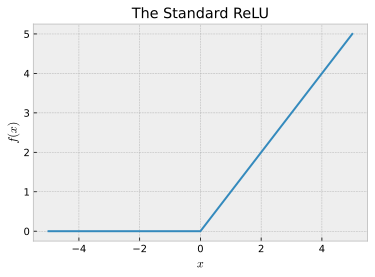

In [4]:
n = 201
x = torch.linspace(-5, 5, steps=n, requires_grad=True)
y = F.relu(x)
plt.plot(x.detach().numpy(), y.detach().numpy())
plt.title('The Standard ReLU')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

The ReLU is sub-differentiable and a sub-derivative
of the ReLU is

$$f'(x) = \begin{cases}
0 &\text{if } x < 0 \\
1 &\text{if } x \geq 0, \\
\end{cases}$$

We can use PyTorch's automatic differentiation capabilities
to easily obtain this derivative:

/home/joe/para_prog_learning/venv/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Text(0, 0.5, "$f'(x)$")

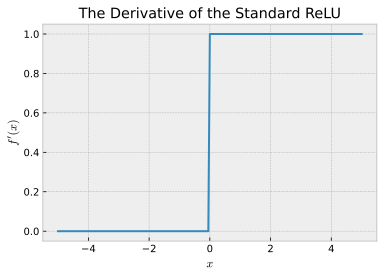

In [5]:
y.sum().backward()
plt.plot(to_np(x), to_np(x.grad))
plt.title('The Derivative of the Standard ReLU')
plt.xlabel('$x$')
plt.ylabel('$f\'(x)$')

From a variational perspective, we can interpret the ReLU as projecting
a point $x\in\mathbb{R}^n$ onto the non-negative orthant as
\begin{equation}
  \hat y = {\rm argmin}_y \;\; \frac{1}{2}||y-x||_2^2 \;\; {\rm s.t.} \;\; y\geq 0.
\end{equation}
The usual explicit solution can be obtained by taking the
first-order optimality conditions as proved in
[Section 2.4 here](https://github.com/bamos/thesis).

Using `cvxpylayers`, we are able to easily implement
this optimization problem as a PyTorch layer.
This is powerful since it does not require that
our optimization problem has an explicit closed-form
solution (even though the ReLU does) and this
also shows how easy we can now take this optimization
problem and tweak it if we wanted to do so, without
having to re-derive the appropriate solution and
backwards pass.
First we implement the problem as usual with CVXPY:

In [6]:
_x = cp.Parameter(n)
_y = cp.Variable(n)
obj = cp.Minimize(cp.sum_squares(_y-_x))
cons = [_y >= 0]
prob = cp.Problem(obj, cons)

And then use one line to create the PyTorch interface:

In [7]:
layer = CvxpyLayer(prob, parameters=[_x], variables=[_y])

And we can plot what this looks like in the same way as before.

Text(0, 0.5, '$f(x)$')

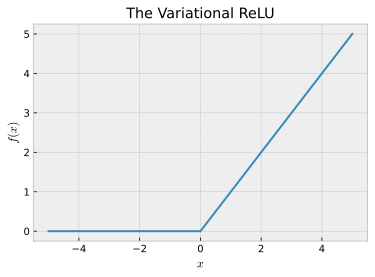

In [8]:
x = torch.linspace(-5, 5, steps=n, requires_grad=True)
y, = layer(x)
plt.plot(to_np(x), to_np(y))
plt.title('The Variational ReLU')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

Since this is computing the same function as the ReLU,
we would expect that the derivative looks the same.
This is indeed true and we have made it so our optimization layer
can be differentiated through just like any other PyTorch layer
using normal PyTorch differentiation.
Obtaining the derivative in the same way as before through
the optimization formulation indeed gives the same result:

Text(0, 0.5, "$f'(x)$")

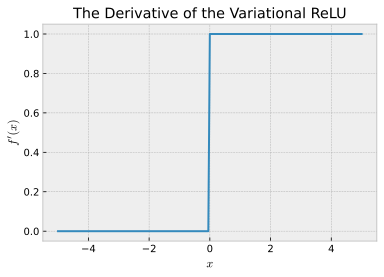

In [9]:
y.sum().backward()
plt.plot(to_np(x), to_np(x.grad))
plt.title('The Derivative of the Variational ReLU')
plt.xlabel('$x$')
plt.ylabel('$f\'(x)$')

For general optimization problems, we may *not* be able to write
out a closed-form solution like for the ReLU here.
From a user's perspective, these details don't matter,
but under the hood we are implicitly differentiating
a set of optimality conditions for this optimization problem,
which we'll go deeper into later.

------

Similarly, **the sigmoid or logistic** activation
function $f(x) = (1+e^{-x})^{-1}$ can
be implemented in PyTorch as:

Text(0, 0.5, '$f(x)$')

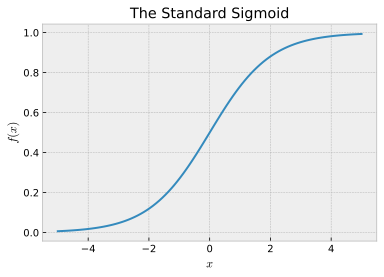

In [10]:
n = 100
x = torch.linspace(-5, 5, steps=n, requires_grad=True)
y = torch.sigmoid(x)
plt.plot(to_np(x), to_np(y))
plt.title('The Standard Sigmoid')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

The derivative of the sigmoid function is
$f'(x)=f(x)(1-f(x))$, which we can again
compute with PyTorch's autodiff:

Text(0, 0.5, '$f(x)$')

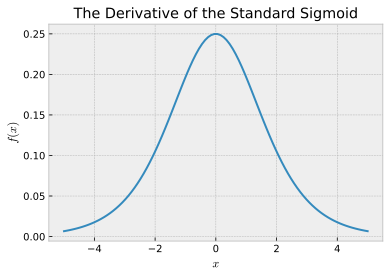

In [11]:
y.sum().backward()
plt.plot(to_np(x), to_np(x.grad))
plt.title('The Derivative of the Standard Sigmoid')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

From an optimization perspective, the sigmoid
projects a point $x\in\mathbb{R}^n$ onto
the interior of the unit hypercube as
\begin{equation}
  f(x) = {\rm argmin}_{0\lt y\lt 1} \; -x^\top y -H_b(y),
\end{equation}
where $H_b(y) = - \left(\sum_i y_i\log y_i + (1-y_i)\log (1-y_i)\right)$ is the
binary entropy function.
This can be proved by looking at the KKT conditions as
done in [Section 2.4 here](https://github.com/bamos/thesis).

We can also implement this in optimization form as:

/home/joe/para_prog_learning/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, '$f(x)$')

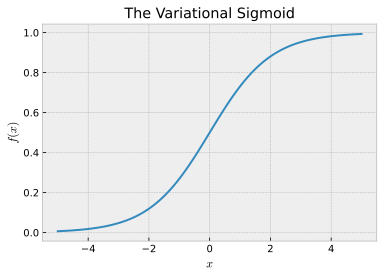

In [14]:
_x = cp.Parameter(n)
_y = cp.Variable(n)
obj = cp.Minimize(-_x.T @ _y - cp.sum(cp.entr(_y) + cp.entr(1.-_y)))
prob = cp.Problem(obj)
layer = CvxpyLayer(prob, parameters=[_x], variables=[_y])
x = torch.linspace(-5, 5, steps=n, requires_grad=True)
y, = layer(x)
plt.plot(x.detach().numpy(), y.detach().numpy())
plt.title('The Variational Sigmoid')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

We can similarly use PyTorch's autodiff to differentiate
through the the optimization formulation of this layer:

/home/joe/para_prog_learning/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, '$f(x)$')

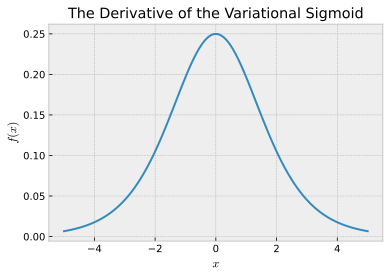

In [15]:
y.sum().backward()
plt.plot(x.detach().numpy(), x.grad.numpy())
plt.title('The Derivative of the Variational Sigmoid')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

Lastly the **softmax** activation function
$f(x)_j = e^{x_j} / \sum_i e^{x_i}$ can
be implemented in PyTorch as follows.
This time we'll consider a single vector
instead of range of values since the softmax is
only interesting in higher dimensions.

In [17]:
d = 5
torch.manual_seed(7)
x = torch.randn(d, requires_grad=True)
y = F.softmax(x, dim=0)

print(f'Input: {to_np(x)}\nOutput: {to_np(y)}')

Input: [-0.1467951   0.7861413   0.94682163 -1.114344    1.6907902 ]
Output: [0.07582434 0.1927426  0.22633949 0.02881426 0.47627935]


We can check to make sure the output sums to 1.

In [18]:
y.sum().item()

1.0

We can also compute the derivative of some output element
with respect to all of the inputs. Let's consider the
last element since it's the largest.

In [19]:
y[4].backward()

print(f'Gradient: {to_np(x.grad)}')

Gradient: [-0.03611356 -0.09179932 -0.10780083 -0.01372364  0.24943732]


We can again interpret the softmax as projecting a point
$x\in\mathbb{R}^n$ onto
the interior of the $(n-1)$-simplex
$$\Delta_{n-1}=\{p\in\mathbb{R}^n\; \vert\; 1^\top p = 1 \; \; {\rm and} \;\; p \geq 0 \}$$
as
\begin{equation}
  f(x) = {\rm argmin}_{0\lt y\lt 1} \;\; -x^\top y - H(y) \;\; {\rm s.t.}\;\; 1^\top y = 1
\end{equation}
where $H(y) = -\sum_i y_i \log y_i$ is the entropy function.
This is also proved in [Section 2.4 here](https://github.com/bamos/thesis)
by using the KKT conditions.
We can implement the variational form of the softmax with:

In [22]:
_x = cp.Parameter(d)
_y = cp.Variable(d)
obj = cp.Minimize(-_x.T @ _y - cp.sum(cp.entr(_y)))
cons = [np.ones(d, dtype=np.float32).T @ _y == 1.]
prob = cp.Problem(obj, cons)
layer = CvxpyLayer(prob, parameters=[_x], variables=[_y])

torch.manual_seed(7)
x = torch.randn(d, requires_grad=True)
y, = layer(x)

print(f'Input: {to_np(x)}\nOutput: {to_np(y)}')

Input: [-0.1467951   0.7861413   0.94682163 -1.114344    1.6907902 ]
Output: [0.07582434 0.1927426  0.22633947 0.02881426 0.47627935]


/home/joe/para_prog_learning/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The output is the same and sums to 1:

In [23]:
y.sum().item()

1.0

And the gradient is also the same:

In [24]:
y[4].backward()

print(f'Gradient: {to_np(x.grad)}')

Gradient: [-0.03611358 -0.09179929 -0.10780082 -0.01372366  0.24943735]


# Even more layers

We next give a few quick examples re-implementing other
differentiable projections that have been considered in the
literature. For a note on efficiency, solving these problems
in conic form with CVXPY may not be the most efficient and
that in some cases explicit solutions to these problems
also exist that follow from some light analysis.
`cvxpylayers` is still a useful prototyping tool and
convenient way of checking the derivative computation
in these cases.

## The [sparsemax](https://arxiv.org/abs/1602.02068)
This is useful for creating sparse predictions in multi-label classification settings
and in attention-based neural networks for natural language inference.
Even though more efficient implementations exist, in optimization form,
the sparsemax does a Euclidean projection onto
the simplex as
\begin{equation}
\begin{array}{ll}
\mbox{minimize} & ||x-y||_2^2 \\
\mbox{subject to} & 1^\top y = 1, \\
& 0 \leq y \leq 1.
\end{array}
\end{equation}
and can be implemented with:

In [25]:
n = 4
x = cp.Parameter(n)
y = cp.Variable(n)
obj = cp.sum_squares(x-y)
cons = [cp.sum(y) == 1, 0. <= y, y <= 1.]
prob = cp.Problem(cp.Minimize(obj), cons)
layer = CvxpyLayer(prob, [x], [y])

torch.manual_seed(0)
x = torch.randn(n)
y, = layer(x)
print(f'Input: {to_np(x)}\nOutput: {to_np(y)}')

Input: [ 1.5409961  -0.2934289  -2.1787894   0.56843126]
Output: [ 9.8628241e-01 -3.9884401e-10 -8.0997176e-10  1.3717593e-02]


## The [csoftmax](https://www.aclweb.org/anthology/D17-1036/)
This is useful for constraining the outputs of the softmax
to be capped at an upper-bound of $u$ and captures the usual
softmax if $u=1$ and is useful for sequence tagging.
It solves the optimization problem
\begin{equation}
\begin{array}{ll}
  \mbox{minimize} & -x^\top y - H(y) \\
  \mbox{subject to} & 1^\top y = 1, \\ 
  & y \leq u, \\
  & 0 < y < 1.
\end{array}
\end{equation}
and can be implemented with:

In [27]:
n, k = 4, 2
u = torch.full([n], 1./k)
x = cp.Parameter(n)
y = cp.Variable(n)
obj = -x @ y-cp.sum(cp.entr(y))
cons = [cp.sum(y) == 1., y <= u]
prob = cp.Problem(cp.Minimize(obj), cons)
layer = CvxpyLayer(prob, [x], [y])

torch.manual_seed(0)
x = torch.randn(n)
y, = layer(x)
print(f'Input: {to_np(x)}\nOutput: {to_np(y)}')

Input: [ 1.5409961  -0.2934289  -2.1787894   0.56843126]
Output: [0.5000002  0.1420723  0.02156317 0.33636498]


/home/joe/para_prog_learning/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## The [csparsemax](https://arxiv.org/abs/1805.08241)
This is the sparse version of the csoftmax and has applications in
attention-based translation.
It solves the optimization problem
\begin{equation}
\begin{array}{ll}
  \mbox{minimize} & ||x-y||_2^2, \\
  \mbox{subject to} & 1^\top y = 1, \\
  & 0 \leq y \leq u.
\end{array}
\end{equation}
and can be implemented with:

In [28]:
n, k = 4, 2
u = torch.full([n], 1./k)

x = cp.Parameter(n)
y = cp.Variable(n)
obj = cp.sum_squares(x-y)
cons = [cp.sum(y) == 1., 0. <= y, y <= u]
prob = cp.Problem(cp.Minimize(obj), cons)
layer = CvxpyLayer(prob, [x], [y])

torch.manual_seed(0)
x = torch.randn(n)
y, = layer(x)
print(f'Input: {to_np(x)}\nOutput: {to_np(y)}')

Input: [ 1.5409961  -0.2934289  -2.1787894   0.56843126]
Output: [ 5.000000e-01  3.033206e-11 -6.598114e-12  5.000000e-01]


## The [Limited Multi-Label Projection (LML) Layer](https://arxiv.org/abs/1906.08707)
The LML layer is useful to directly optimize the model's
top-k error or recall in multi-label settings instead of
a surrogate.
It solves the optimization problem
\begin{equation}
\begin{array}{ll}
  \mbox{minimize} & -x^\top y - H_b(y) \\
  \mbox{subject to} & 1^\top y = k, \\
  & 0 < y < 1.
\end{array}
\end{equation}
and can be implemented with:

In [30]:
n, k = 4, 2

x = cp.Parameter(n)
y = cp.Variable(n)
obj = -x @ y-cp.sum(cp.entr(y))-cp.sum(cp.entr(1.-y))
cons = [cp.sum(y) == k]
prob = cp.Problem(cp.Minimize(obj), cons)
layer = CvxpyLayer(prob, [x], [y])
torch.manual_seed(0)
x = torch.randn(n)
y, = layer(x)
print(f'Input: {to_np(x)}\nOutput: {to_np(y)}')

Input: [ 1.5409961  -0.2934289  -2.1787894   0.56843126]
Output: [0.8254717  0.43031406 0.10285254 0.64136344]


/home/joe/para_prog_learning/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Learnable Parametrized Optimization Layers
Up until this point, our toy optimization layers have not been
had any learnable components and didn't add any new modeling
functionality.
In this part, we will show how to
use an optimization layer to learn a parametrized objective function
and hard constraints  from data that are initially unknown
to the model.
From a parameter learning perspective, this layer can be
interpreted as another differentiable black box and the
parameters can be treated just as any other layers' parameters
and learned with gradient-based updates.

## The OptNet QP
We'll start with the [OptNet QP](https://arxiv.org/abs/1703.00443),
which in the most general form is expressed as
\begin{equation}
\begin{split}
y = {\rm argmin}_{x} \;\; & \frac{1}{2} x^T Qx + q^T x \\
{\rm subject\; to} \;\; & Ax  = b \\
& Gx\leq h
\end{split}
\label{eq:qp}
\end{equation}

We can re-implement this using CVXPY with a few lines
of code:

In [32]:
n, m, p = 10, 5, 5
Q_sqrt = cp.Parameter((n, n))
q = cp.Parameter(n)
A = cp.Parameter((m, n))
b = cp.Parameter(m)
G = cp.Parameter((p, n))
h = cp.Parameter(p)
x = cp.Variable(n)
obj = cp.Minimize(0.5*cp.sum_squares(Q_sqrt @ x) + q.T @ x)
cons = [A @ x == b, G @ x <= h]
prob = cp.Problem(obj, cons)
layer = CvxpyLayer(prob, parameters=[Q_sqrt, q, A, b, G, h], variables=[x])

/home/joe/para_prog_learning/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


And we can use the layer with the following. As a caveat
that is discussed in the OptNet paper, this QP should
be formulated so that it is always feasible.
(This may not always happen with the following sampling.)

In [33]:
torch.manual_seed(0)
Q_sqrtval = torch.randn(n, n, requires_grad=True)
qval = torch.randn(n, requires_grad=True)
Aval = torch.randn(m, n, requires_grad=True)
bval = torch.randn(m, requires_grad=True)
Gval = torch.randn(p, n, requires_grad=True)
hval = torch.randn(p, requires_grad=True)
y, = layer(Q_sqrtval, qval, Aval, bval, Gval, hval)
print('Output: ', to_np(y))

Output:  [ 0.33921835  0.37941813  0.22012089 -0.01115532 -0.31207854 -0.22344513
  0.5120356  -0.30485317 -0.11274898  0.21256383]


The resulting `layer` object here solves the QP in conic form
and almost has the same performance as the specialized differentiable
batched QP library [qpth](https://github.com/locuslab/qpth)
released with OptNet:

![](./prof.png)

Once we add support for differentiating QPs internally to
CVXPY the performance will likely be faster than `qpth`,
especially for sparse QPs.
Another power of using CVXPY for creating these layers is that
you no longer need to manually canonicalize your problems into
standard QP form as we show here as `qpth` required.
You can express your problem in a form closer to the math.

## General Polytope Projections
In this next example we'll look at a simple
polytope learning problem of learning a
polytope $\{x : Gx \leq h\}$ from data.
Suppose we have data generated by projecting
points onto some polytope by solving the optimization
problem

\begin{equation}
\begin{split}
\hat y = {\rm argmin}_y\;\; &\frac{1}{2}||x-y||_2^2  \\
{\rm s.t.}\;\; & Gy \leq h.
\end{split}
\end{equation}

The solution to this optimization problem does **not** have an
explicit closed-form solution in general and is therefore
not as straightforward to integrate as a layer
for machine learning.
Using CVXPY, we can implement this layer in a few lines of code with:

In [35]:
nx, ncon = 2, 10

_G = cp.Parameter((ncon, nx))
_h = cp.Parameter(ncon)
_x = cp.Parameter(nx)
_y = cp.Variable(nx)
obj = cp.Minimize(0.5*cp.sum_squares(_x-_y))
cons = [_G @ _y <= _h]
prob = cp.Problem(obj, cons)

layer = CvxpyLayer(prob, parameters=[_G, _h, _x], variables=[_y])

/home/joe/para_prog_learning/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Note that here, $x$, $G$, and $h$ are all `Parameter` objects
as inputs to the optimization layer, even though we would
usually consider $x$ an input to the layer and $G$ and $h$
the parameters.

We can now randomly initialize a polytope as the ground-truth polytope:

/home/joe/para_prog_learning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))


(<Figure size 360x360 with 1 Axes>, <AxesSubplot:>)

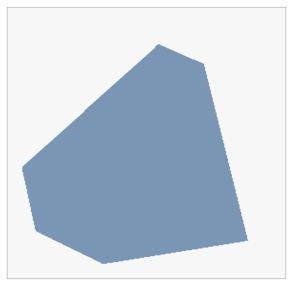

In [36]:
torch.manual_seed(6)
G = torch.FloatTensor(ncon, nx).uniform_(-4, 4)
z0 = torch.full([nx], 0.5)
s0 = torch.full([ncon], 0.5)
h = G.mv(z0)+s0
plotConstraints(to_np(G), to_np(h))

And we can project a point onto it with:

In [37]:
torch.manual_seed(0)
x = torch.randn(nx)
y, = layer(G, h, x)
print(f'Input: {to_np(x)}\nOutput: {to_np(y)}')

Input: [ 1.5409961 -0.2934289]
Output: [0.6635195  0.34164992]


Next to set up the learning problem we can initialize
another polytope that we show here as red:

/home/joe/para_prog_learning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
/home/joe/para_prog_learning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


(<Figure size 360x360 with 1 Axes>, <AxesSubplot:>)

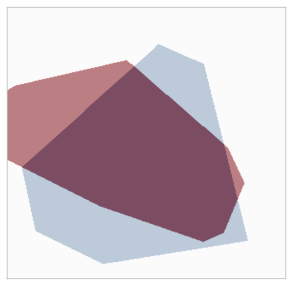

In [38]:
torch.manual_seed(22)
G_hat = nn.Parameter(torch.FloatTensor(ncon, nx).uniform_(-4, 4).requires_grad_())
h_hat = G_hat.mv(z0)+s0
plotConstraints(to_np(G), to_np(h), to_np(G_hat), to_np(h_hat))

Our goal is to now to look at the data to learn the
true underlying polytope. In a larger, real-world application,
the true, unknown polytope may represent physical or
latent constraints on the data that you are trying
and you want to try to learn those with an explicit polytope.
The following is the usual paradigm of initializing an optimizer
to learn this new polytope and then updating it with gradients
coming from a loss function. As part of this, we are
differentiating the output of the optimization problem
with respect to an underlying hard constraint and
using this for learning.

In [39]:
opt = torch.optim.Adam([G_hat], lr=1e-2)
losses = []

d = 'polytope_images'
if os.path.exists(d):
    shutil.rmtree(d)
os.makedirs(d)

In [42]:
for i in range(2500):
    x = torch.randn(nx)
    y, = layer(G, h, x)
    
    h_hat = G_hat.mv(z0)+s0
    yhat, = layer(G_hat, h_hat, x)
    loss = (yhat-y).norm()
    losses.append(loss)
    
    if i % 50 == 0:
        print(i)
#         fig, ax = plotConstraints(to_np(G), to_np(h), to_np(G_hat), to_np(h_hat))
#         fig.tight_layout()
#         fig.savefig(f'{d}/{i:04d}.png')
#         plt.close(fig)
        
        
    opt.zero_grad()
    loss.backward()
    opt.step()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450


We can look at the losses and see that we've converged
to something reasonable:

(0.0, 0.13104204739793204)

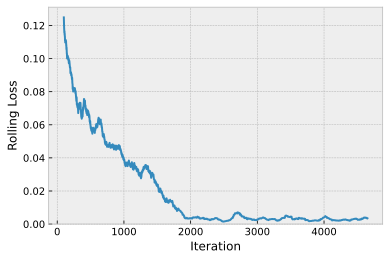

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
N = 100
xs = np.arange(N-1, len(losses))
ys = np.convolve(losses, np.full(N, 1./N), mode='valid')
ax.plot(xs, ys)
ax.set_xlabel('Iteration')
ax.set_ylabel('Rolling Loss')
ax.set_ylim(0, None)

And we can use [ImageMagick](https://imagemagick.org/index.php) to
create an animation from the frames during training showing
our model converging to the true polytope.

In [44]:
os.system(f'convert -delay 10 -loop 0 {d}/????.png {d}/animation.gif');

/home/joe/para_prog_learning/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


![Visualization of the polytope learning during training](./polytope_images/animation.gif)

Here's what the learning process looks like for a few other examples:

![More visualizations of the polytope learning during training](./polytope-learning.gif)

A few last comments here: These approximate polytopes are not able to
learn how to add new edges since this remains fixed throughout the
training process, which you can see happen in the bottom-left.
And as a footnote, a convex hull on the projections *could* be
used to solve this problem if you actually care about solving
this problem.
But this could potentially generate as many edges as there
are training data points and our method can be seen as
an approximate convex hull fitting approach.

## Ellipsoid Projections

Suppose instead that we want to constrain our latent space
to be on an ellipsoid instead of a polytope.
Our projection layer now becomes
\begin{equation}
\begin{split}
\hat y = {\rm argmin}_y\;\; &\frac{1}{2}||x-y||_2^2  \\
 {\rm s.t.}\;\; & \frac{1}{2}(y-z)^\top A(y-z) \leq 1.
\end{split}
\end{equation}
This is mathematically interesting as it shows an example
of differentiating through a non-polyhedral cone program.
We can try these layers out by just changing the
constraints of our optimization problem:

In [33]:
_A = cp.Parameter((n, n))
_z = cp.Parameter(n)
_x = cp.Parameter(n)
_y = cp.Variable(n)
_t = cp.Variable(n)
obj = cp.Minimize(0.5 * cp.sum_squares(_x - _y))
cons = [0.5 * cp.sum_squares(_A * _t) <= 1, _t == (_y - _z)]
prob = cp.Problem(obj, cons)

layer = CvxpyLayer(prob, parameters=[_A, _z, _x], variables=[_y, _t])

Noting that in this case we needed to manually
construct $t=y-z$ for our problem to be
[DPP-compliant](https://www.cvxpy.org/tutorial/advanced/index.html#dpp)
as otherwise we would have been multiplying two `Parameter` objects.
We can similarly visualize the learning process of four ellipsoids:

![Visualization of the ellipsoid learning](./ellipsoid-learning2.gif)

# Even more examples

![](even-more-examples.png)

In our paper we also show examples in data poisoning and
stochastic control. You can find complete notebooks reproducing
these examples [in our repo](https://github.com/cvxgrp/cvxpylayers/tree/master/examples)
and we provide the complete
[PyTorch implementation](https://github.com/cvxgrp/cvxpylayers/tree/master/examples/torch)
and
[TensorFlow implementation](https://github.com/cvxgrp/cvxpylayers/tree/master/examples/torch)
for these experiments, highlighting how easy differentiable
convex optimization layers are to use with TensorFlow too.

# How does all of this work?

![](overview2.png)

You can see the full details in [our paper](http://web.stanford.edu/~boyd/papers/pdf/diff_cvxpy.pdf).
Our insight is that we can:

1. Map from the CVXPY parameters to an internal cone program
(or other canonical representational) in a differentiable way.
We have significantly modified CVXPY to do this with
an affine map.
2. We can differentiate through the cone program
by implicitly differentiating a residual map
as discussed in
[Section 7.3 here](https://github.com/bamos/thesis)
and [here](https://arxiv.org/abs/1904.09043).
This captures KKT differentiation as a special
case.
3. We can map from the cone program solution
back to the original problem solution in
a differentiable way.

We refer to this as affine-solver-affine (ASA)
form and can differentiate through every step of
it, thus allowing us to create differentiable
optimization layers with CVXPY.

# Summary and Future Directions

Our library enables the rapid prototyping of differentiable
convex optimization layers in a flexible way that no
longer requires manual canonicalization, can be
used with PyTorch and TensorFlow, and can
efficiently batch up the forward and backward passes.
We plan to actively maintain and support this code
and are working on adding on even more performance
improvements and features.
Get in touch if you start using our code and
let us know if you have any issues or contributions!

----

[Download post as jupyter notebook](cvxpylayers.tar.gz)